In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 10 variables share a factor structure and the other 20 are noise

In [2]:
N = 50000
D_factor = 10
D_noise = 20
D = D_factor + D_noise
P = 3

V = np.abs(np.random.normal(1.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0.5, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor+D_noise))
X = np.random.poisson(1.,size=(N,D_noise+D_factor))
X[:, ::3] = np.random.poisson(ZV)

In [3]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(10000)

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True, 
    u_tau_scale=1.0/P/D/np.sqrt(N),
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 3


In [5]:
losses = factor.calibrate_advi(
    num_epochs=100, learning_rate=.1)




W0521 16:00:17.248688 4505066944 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 75.28101396749064
Epoch 1: average-batch loss: 64.85143168317026 last batch loss: 55.55589233249532
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 54.48019288042502 last batch loss: 50.45165054945681
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 48.776314140836845 last batch loss: 47.63324848602863
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 46.46797312076694 last batch loss: 46.31263929481624
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 45.906985455274025 last batch loss: 45.832765969320924
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 45.90344302195996 last batch loss: 45.98910719245685
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 45.9026946338336 last batch loss: 45.9219845046072
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 45.921557691498336 last batch loss: 45.84915424384756
We are in a loss plateau learn

Epoch 69: average-batch loss: 41.54651632369646 last batch loss: 41.46363116099815
Saved a checkpoint: ./.tf_ckpts/chkpt-62
Epoch 70: average-batch loss: 41.52058244814022 last batch loss: 41.453646076353735
Saved a checkpoint: ./.tf_ckpts/chkpt-63
Epoch 71: average-batch loss: 41.488071024841325 last batch loss: 41.42759641558407
Saved a checkpoint: ./.tf_ckpts/chkpt-64
Epoch 72: average-batch loss: 41.47964911357321 last batch loss: 41.39254437901493
Saved a checkpoint: ./.tf_ckpts/chkpt-65
Epoch 73: average-batch loss: 41.447866206437894 last batch loss: 41.36189653978764
Saved a checkpoint: ./.tf_ckpts/chkpt-66
Epoch 74: average-batch loss: 41.43020990106803 last batch loss: 41.36605369526261
Saved a checkpoint: ./.tf_ckpts/chkpt-67
Epoch 75: average-batch loss: 41.42278690080565 last batch loss: 41.37213875965256
Saved a checkpoint: ./.tf_ckpts/chkpt-68
Epoch 76: average-batch loss: 41.40147837724927 last batch loss: 41.33068469825046
Saved a checkpoint: ./.tf_ckpts/chkpt-69
Epoch

In [6]:
waic = factor.waic()
print(waic)

{'waic': 1288448.479878923, 'se': 1941.7253045640123, 'lppd': -449327.6112633891, 'pwaic': 194896.6286760724}


In [7]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.norm_factor).numpy().T})

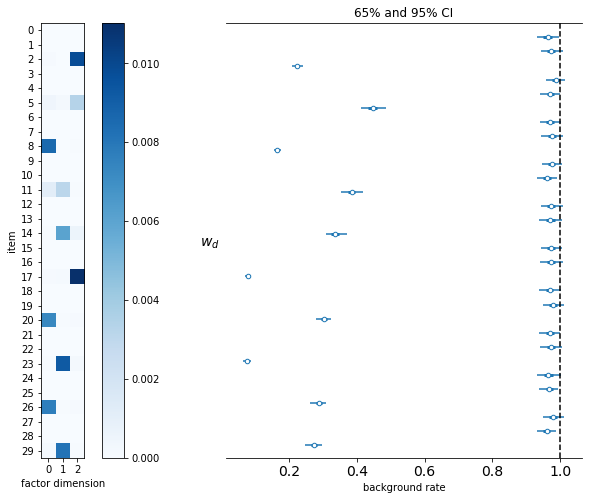

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


In [9]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 30), dtype=float64, numpy=
array([[0.79996504, 0.18564103, 0.18251951, 0.75401789, 0.18494863,
        0.18532607, 0.87395262, 0.19110349, 0.18428356, 0.74197791,
        0.18905013, 0.18387423, 0.88040365, 0.18707459, 0.18591149,
        0.73500579, 0.18443368, 0.18330621, 0.70845106, 0.1839532 ,
        0.18489199, 0.84254488, 0.17864647, 0.18092461, 0.65214002,
        0.1800987 , 0.17968506, 0.80946376, 0.18849412, 0.18602095],
       [0.20003496, 0.81435897, 0.81748049, 0.24598211, 0.81505137,
        0.81467393, 0.12604738, 0.80889651, 0.81571644, 0.25802209,
        0.81094987, 0.81612577, 0.11959635, 0.81292541, 0.81408851,
        0.26499421, 0.81556632, 0.81669379, 0.29154894, 0.8160468 ,
        0.81510801, 0.15745512, 0.82135353, 0.81907539, 0.34785998,
        0.8199013 , 0.82031494, 0.19053624, 0.81150588, 0.81397905]])>